In [21]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from mne.time_frequency import tfr_array_morlet
import mne
import pandas as pd
import seaborn as sns
from LoadData import Data # from Jiating's Data class
import sys
import scipy.io 

In [22]:
# functions from topNch.ipynb (Jiating): getting top 50 visually evoked responses
def get_ranked_ch(sessionDir, data_exp='TA2'):
    """Get ranked channels for a session.
    
    Parameters:
    -----------
    sessionDir : str
        Session directory name (e.g., 'R1187_20181119')
    data_exp : str
        Experiment type ('TA2' or 'noise')
        
    Returns:
    --------
    rankedCh : array
        Array of ranked channel indices
    """
    if data_exp == 'noise':
        Pk_avgProm_path = "/projectnb/rdenlab/Data/TANoise/MEG/%s/mat/channels_20Hz_ebi.mat" % sessionDir
        Pk_avgProm_path2 = "/projectnb/rdenlab/Data/TANoise/MEG/%s/channels_20Hz_ebi.mat" % sessionDir
    else:
        Pk_avgProm_path = "/projectnb/rdenlab/Data/TA2/MEG/%s/mat/Pk_avgProm.mat" % sessionDir
        Pk_avgProm_path2 = "/projectnb/rdenlab/Data/TA2/MEG/%s/Pk_avgProm.mat" % sessionDir
    
    try:
        Pk_avgProm_mat = scipy.io.loadmat(Pk_avgProm_path)
    except:
        Pk_avgProm_mat = scipy.io.loadmat(Pk_avgProm_path2)

    if data_exp == 'noise':
        rankedCh = Pk_avgProm_mat['channelsRanked'][0]
    else:
        rankedCh = Pk_avgProm_mat['Pk']['idxDirProm'][0][0][:, 0]

    return rankedCh

def get_dataX(sessionDir, bietfpDir, data_exp='TA2', topN=50):
    """Load data with bad trials removed and top N channels.
    
    Parameters:
    -----------
    sessionDir : str
        Session directory name
    bietfpDir : str
        BIETFP directory name
    data_exp : str
        Experiment type ('TA2' or 'noise')
    topN : int
        Number of top channels to select (0 for all channels)
        
    Returns:
    --------
    data : Data object
        Data object with X attribute containing cleaned data
    """
    # Load data
    data = Data(sessionDir, bietfpDir)
    
    # Remove bad trials
    try:
        reject_trial_str1 = "/projectnb/rdenlab/Data/TA2/MEG/%s/mat/trials_rejected.mat" % sessionDir
        reject_trial_mat = scipy.io.loadmat(reject_trial_str1)
    except:
        reject_trial_str2 = "/projectnb/rdenlab/Data/TA2/MEG/%s/prep/trials_rejected.mat" % sessionDir
        reject_trial_mat = scipy.io.loadmat(reject_trial_str2)
    
    reject_trial_arr = reject_trial_mat['trials_rejected']
    # if index of rejected trials is valid
    if not (np.squeeze(reject_trial_arr) > np.shape(data.X)[2]).any():
        data.X[:, :, reject_trial_arr - 1] = None

    # Get ranked channels and select top N
    if topN > 0:
        rankedCh = get_ranked_ch(sessionDir, data_exp)
        data.X = data.X[:, rankedCh[:topN] - 1, :]
    
    return data

"""
data.X - This is the main MEG data array with shape (4401, 157, 516) where:

4401 is the number of time points in the recording
157 is the number of MEG channels/sensors
516 is the number of trials


data.y - The tilt response values from the behavioral data
data.not_nan_idx - Indices where tilt_response > 0 (valid responses)
data.X_nan_removed - MEG data with NaN responses removed
data.y_nan_removed - Tilt response values with NaN values removed
Trial classification attributes:

data.correct_idxs - Indices of trials with correct responses
data.incorrect_idxs - Indices of trials with incorrect responses
data.neutral_idxs - Indices of neutral trials (cueValidity = 0)
data.valid_idxs - Indices of valid trials (cueValidity = 1)
data.invalid_idxs - Indices of invalid trials (cueValidity = -1)


Cue and target related attributes:

data.cuedTarget - Target indicated by the precue
data.raw_cue1_idx - Indices where cuedTarget = 1
data.raw_cue2_idx - Indices where cuedTarget = 2
data.responseTarget - Target indicated by the response cue
data.cueValidity - Validity of the cue
data.precue_T1, data.precue_T2 - Indices where cuedTarget is 1 or 2 (1 for T1, 2 for T2)
data.respcue_T1, data.respcue_T2 - Indices where responseTarget is 1 or 2


Time window attributes for analysis:

data.pstart - Start time for preprocessing (-500 ms)
data.time_window_T1, data.time_window_T2 - Time windows for targets
Various other time window definitions for analysis
"""

'\ndata.X - This is the main MEG data array with shape (4401, 157, 516) where:\n\n4401 is the number of time points in the recording\n157 is the number of MEG channels/sensors\n516 is the number of trials\n\n\ndata.y - The tilt response values from the behavioral data\ndata.not_nan_idx - Indices where tilt_response > 0 (valid responses)\ndata.X_nan_removed - MEG data with NaN responses removed\ndata.y_nan_removed - Tilt response values with NaN values removed\nTrial classification attributes:\n\ndata.correct_idxs - Indices of trials with correct responses\ndata.incorrect_idxs - Indices of trials with incorrect responses\ndata.neutral_idxs - Indices of neutral trials (cueValidity = 0)\ndata.valid_idxs - Indices of valid trials (cueValidity = 1)\ndata.invalid_idxs - Indices of invalid trials (cueValidity = -1)\n\n\nCue and target related attributes:\n\ndata.cuedTarget - Target indicated by the precue\ndata.raw_cue1_idx - Indices where cuedTarget = 1\ndata.raw_cue2_idx - Indices where cue

In [23]:
# for the purpose of determining the pipeline, work with just one session here
sessionDir = 'R1187_20181119'
bietfpDir = 'R1187_TA2_11.19.18'
data_all = Data(sessionDir, bietfpDir)
data_exp = 'TA2'
topN = 50
# get_dataX: returns Data object (or DataNoise object if data_exp='noise'), 
# which contains MEG data with bad trials removed and optionally filtered to include only the top N ranked channels
data_top50 = get_dataX(sessionDir, bietfpDir, data_exp, topN) 


In [24]:
# check data shapes: all channels, after top 50 channel selection, T1 & T2
print(f"MEG data with all channels shape: {data_all.X.shape}")  # should be (4401, 157, 516) (epochs, channels, timepoints within each epoch)
print(f"MEG data shape after top 50 channel selection: {data_top50.X.shape}") # should be (4401, 50, 516)

# this should be all the same
print(f"Number of T1-cued trials for all channels: {len(data_all.precue_T1)}")
print(f"Number of T2-cued trials for all channels: {len(data_all.precue_T2)}")
print(f"Number of T1-cued trials for top 50 channels: {len(data_all.precue_T1)}")
print(f"Number of T2-cued trials for top 50 channels: {len(data_all.precue_T2)}")

MEG data with all channels shape: (4401, 157, 516)
MEG data shape after top 50 channel selection: (4401, 50, 516)
Number of T1-cued trials for all channels: 192
Number of T2-cued trials for all channels: 192
Number of T1-cued trials for top 50 channels: 192
Number of T2-cued trials for top 50 channels: 192


In [25]:
# Get anticipatory periods from precue (t=0) to T1 (t=1050)

# get anticipatory period signal from all channels for both when participants are instructed to atten to either T1 and T2
anticipatory_t1_all_channels = data_all.X[0:1550, :, data_all.precue_T1]  # All channels
print(f"All channel anticipatory T1 data shape: {anticipatory_t1_all_channels.shape}")

anticipatory_t2_all_channels = data_all.X[0:1550, :, data_all.precue_T2]  # All channels
print(f"All channel anticipatory T2 data shape: {anticipatory_t1_all_channels.shape}")

# get anticipatory period signal from top 50 channels for both T1 and T2
anticipatory_t1_top50_channels = data_top50.X[0:1550, :, data_top50.precue_T1] 
print(f"Top 50 channel anticipatory T1 data shape: {anticipatory_t1_top50_channels.shape}")

anticipatory_t2_top50_channels = data_top50.X[0:1550, :, data_top50.precue_T2] 
full_t1_data = data_top50.X[0:1550, :, data_top50.precue_T1]
full_t2_data = data_top50.X[0:1550, :, data_top50.precue_T2]
print(f"Full T1 data with pre-precue period shape: {full_t1_data.shape}")
print(f"Full T2 data with pre-precue period shape: {full_t2_data.shape}")

np.save('anticipatory_t1_top50_channels.npy', anticipatory_t1_top50_channels)
np.save('anticipatory_t2_top50_channels.npy', anticipatory_t2_top50_channels)
np.save('anticipatory_t1_all_channels.npy', anticipatory_t1_all_channels)
np.save('anticipatory_t2_all_channels.npy', anticipatory_t2_all_channels)
np.save('full_t1_data.npy', full_t1_data)
np.save('full_t2_data.npy', full_t2_data)

print("Data saved to disk.")

All channel anticipatory T1 data shape: (1550, 157, 192)
All channel anticipatory T2 data shape: (1550, 157, 192)
Top 50 channel anticipatory T1 data shape: (1550, 50, 192)
Full T1 data with pre-precue period shape: (1550, 50, 192)
Full T2 data with pre-precue period shape: (1550, 50, 192)
Data saved to disk.


# Power Spectrum Plot
visualizing the distribution of signal power across different frequencies
x: frequency
y: power with fast fourier transform 

- frequency vs. power plotted, log-log scale

In [26]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [27]:
sfreq = 1000  # sampling frequency
n_cycles = 7   # number of cycles of the wavelet used to analyze each frequency
freqs = np.arange(4, 30, 2)  # From 4 to 29 Hz

In [28]:
# for sanity checking purposes, just extract the first trial
first_t1_trial = anticipatory_t1_top50_channels[:, 0, 0]  # First time series, first channel, first trial
first_t2_trial = anticipatory_t2_top50_channels[:, 0, 0]  # First time series, first channel, first trial

# apply FFT
fft_t1 = np.fft.fft(first_t1_trial)
fft_t2 = np.fft.fft(first_t2_trial)

# get frequencies
n = len(first_t1_trial)
freq = np.fft.fftfreq(n, 1/sfreq)

# get power
power_t1 = np.abs(fft_t1)**2
power_t2 = np.abs(fft_t2)**2

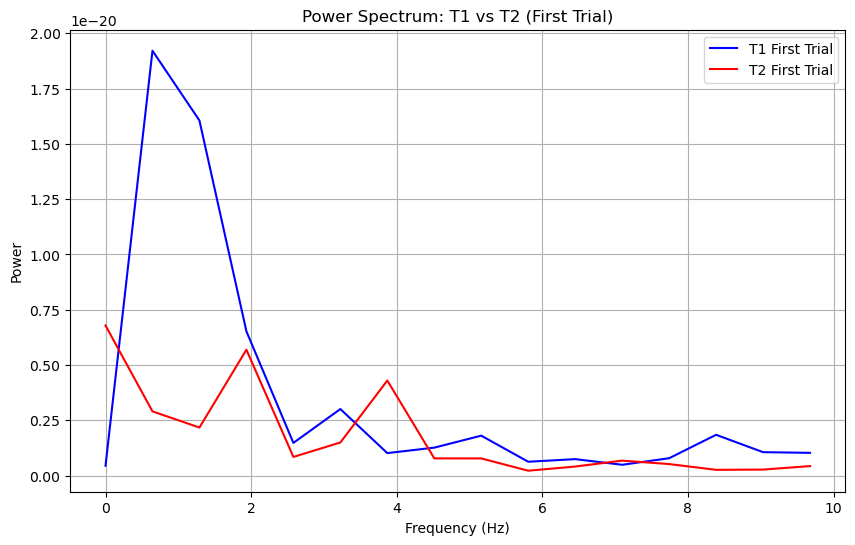

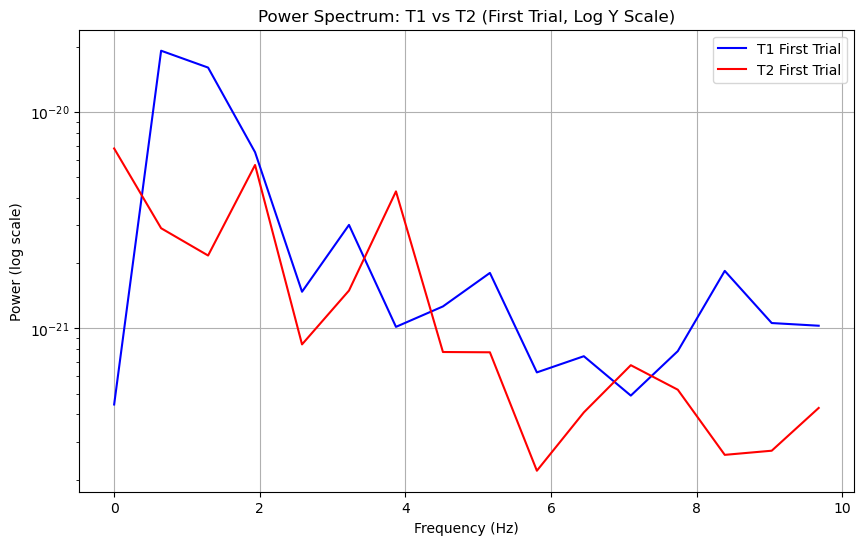

In [ ]:
# plot just positive frequencies up to 10 Hz
plt.figure(figsize=(10, 6))
mask = (freq >= 0) & (freq <= 10)

# Plot T1 and T2 on same axes
plt.plot(freq[mask], power_t1[mask], 'b-', label='T1 First Trial')
plt.plot(freq[mask], power_t2[mask], 'r-', label='T2 First Trial')

plt.title('Power Spectrum: T1 vs T2 (First Trial)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.savefig('t1_vs_t2_single_trial.png')
plt.show()

#  try log scale
plt.figure(figsize=(10, 6))
plt.semilogy(freq[mask], power_t1[mask], 'b-', label='T1 First Trial')
plt.semilogy(freq[mask], power_t2[mask], 'r-', label='T2 First Trial')

plt.title('Power Spectrum: T1 vs T2 (First Trial, Log Y Scale)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (log scale)')
plt.legend()
plt.grid(True)
# plt.savefig('t1_vs_t2_single_trial_log.png')
plt.show()

In [30]:
# Load the data from disk
import numpy as np
anticipatory_t1_top50_channels = np.load('anticipatory_t1_top50_channels.npy')
anticipatory_t2_top50_channels = np.load('anticipatory_t2_top50_channels.npy')
anticipatory_t1_all_channels = np.load('anticipatory_t1_all_channels.npy')
anticipatory_t2_all_channels = np.load('anticipatory_t2_all_channels.npy')

full_t1 = np.load('full_t1_data.npy')
full_t2 = np.load('full_t2_data.npy')

Processing T1 trials
  Trial 25: Contains NaN values, skipping
  Trial 32: Contains NaN values, skipping
  Trial 33: Contains NaN values, skipping
  Trial 51: Contains NaN values, skipping
  Trial 65: Contains NaN values, skipping
  Trial 81: Contains NaN values, skipping
  Trial 92: Contains NaN values, skipping
  Trial 111: Contains NaN values, skipping
  Trial 113: Contains NaN values, skipping
  Trial 116: Contains NaN values, skipping
  Trial 128: Contains NaN values, skipping
  Trial 157: Contains NaN values, skipping
  Trial 164: Contains NaN values, skipping
  Trial 165: Contains NaN values, skipping
  Trial 166: Contains NaN values, skipping
  Trial 171: Contains NaN values, skipping
  Trial 172: Contains NaN values, skipping
  Trial 176: Contains NaN values, skipping
  Trial 185: Contains NaN values, skipping
Valid T1 trials: 173 out of 192
Processing T2 trials
  Trial 11: Contains NaN values, skipping
  Trial 18: Contains NaN values, skipping
  Trial 23: Contains NaN values,

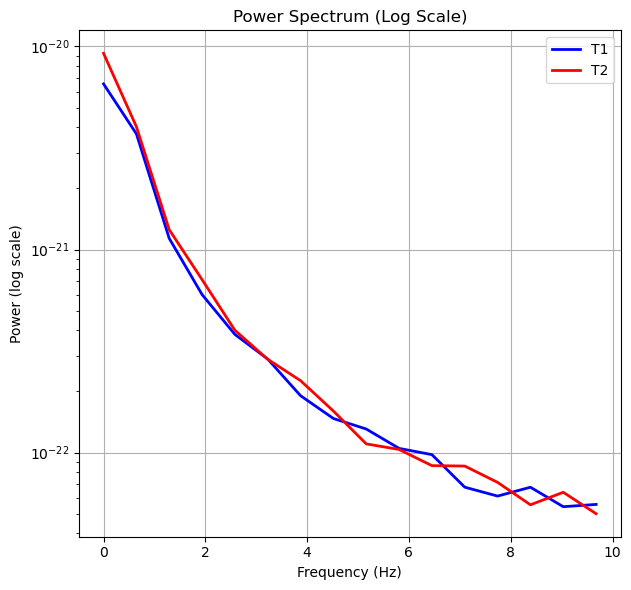

In [31]:
import numpy as np
import matplotlib.pyplot as plt
# apply to all trials (excluding ones with NaN values); calculate FFT for each trial individually
# keep lists to store power spectra for each trial
n_freqs = anticipatory_t1_top50_channels.shape[0] // 2 + 1  # Number of positive frequencies
t1_powers = []  
t2_powers = []

# scaling_factor = 1e15

# go through T1 trials
print("Processing T1 trials")
for i in range(anticipatory_t1_top50_channels.shape[2]):
    # average across 50 channels for this trial to get a single time series
    trial_data = np.mean(anticipatory_t1_top50_channels[:, :, i], axis=1) 
    
    # filter  NaN values
    if np.isnan(trial_data).any():
        print(f"  Trial {i}: Contains NaN values, skipping")
        continue
    
    # Scale  data
    # trial_data = trial_data * scaling_factor
    
    # get FFT and power
    fft_result = np.fft.rfft(trial_data)
    power = np.abs(fft_result)**2
    
    # Check if power values are valid
    if np.isnan(power).any():
        print(f"  Trial {i}: Power calculation resulted in NaN, skipping")
        continue
    
    t1_powers.append(power)
    
print(f"Valid T1 trials: {len(t1_powers)} out of {anticipatory_t1_top50_channels.shape[2]}")

#  go through T2 trials
print("Processing T2 trials")
for i in range(anticipatory_t2_top50_channels.shape[2]):
    # average across 50 channels for this trial
    trial_data = np.mean(anticipatory_t2_top50_channels[:, :, i], axis=1)
    
    # filter  NaN values
    if np.isnan(trial_data).any():
        print(f"  Trial {i}: Contains NaN values, skipping")
        continue
    
    # scale  data
    # trial_data = trial_data * scaling_factor
    
    # get FFT and power
    fft_result = np.fft.rfft(trial_data)
    power = np.abs(fft_result)**2
    
    # Check if power values are valid
    if np.isnan(power).any():
        print(f"  Trial {i}: Power calculation resulted in NaN, skipping")
        continue
    
    t2_powers.append(power)

print(f"Valid T2 trials: {len(t2_powers)} out of {anticipatory_t2_top50_channels.shape[2]}")

#  edge case: no valid trials
if len(t1_powers) == 0 or len(t2_powers) == 0:
    print("Not enough valid trials to create power spectra")
else:
    # Convert lists to numpy arrays
    t1_powers_array = np.array(t1_powers)
    t2_powers_array = np.array(t2_powers)
    
    # average across trials
    avg_t1_power = np.mean(t1_powers_array, axis=0)
    avg_t2_power = np.mean(t2_powers_array, axis=0)
    
    # Calculate frequencies
    freq = np.fft.rfftfreq(anticipatory_t1_top50_channels.shape[0], 1/sfreq)
    
    # Print info
    print(f"Frequency shape: {freq.shape}")
    print(f"Power shape: {avg_t1_power.shape}")
    print(f"Min/max frequency: {np.min(freq)}, {np.max(freq)}")
    print(f"Min/max T1 power: {np.min(avg_t1_power)}, {np.max(avg_t1_power)}")
    print(f"Min/max T2 power: {np.min(avg_t2_power)}, {np.max(avg_t2_power)}")
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Only plot up to 10 Hz
    mask = freq <= 10

    # Log scale
    plt.subplot(1, 2, 2)
    plt.semilogy(freq[mask], avg_t1_power[mask], 'b-', linewidth=2, label='T1')
    plt.semilogy(freq[mask], avg_t2_power[mask], 'r-', linewidth=2, label='T2')
    plt.title('Power Spectrum (Log Scale)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (log scale)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('power_spectrum_by_trial.png', dpi=300)
    
    print("Plot saved to power_spectrum_by_trial.png")

In [32]:
# checking which trials had NaN

import numpy as np

# Check T1 data for NaNs
print("Checking T1 data for NaNs:")
t1_nan_trials = []

for trial_idx in range(anticipatory_t1_top50_channels.shape[2]):
    if np.isnan(anticipatory_t1_top50_channels[:, :, trial_idx]).any():
        t1_nan_trials.append(trial_idx)

print(f"{len(t1_nan_trials)} trials with NaNs out of {anticipatory_t1_top50_channels.shape[2]} total T1 trials")
if t1_nan_trials:
    print(f"Trial indices with NaNs: {t1_nan_trials}")

# Check T2 data for NaNs
print("\nChecking T2 data for NaNs:")
t2_nan_trials = []

for trial_idx in range(anticipatory_t2_top50_channels.shape[2]):
    if np.isnan(anticipatory_t2_top50_channels[:, :, trial_idx]).any():
        t2_nan_trials.append(trial_idx)

print(f" {len(t2_nan_trials)} trials with NaNs out of {anticipatory_t2_top50_channels.shape[2]} total T2 trials")
if t2_nan_trials:
    print(f"Trial indices with NaNs: {t2_nan_trials}")

Checking T1 data for NaNs:
19 trials with NaNs out of 192 total T1 trials
Trial indices with NaNs: [25, 32, 33, 51, 65, 81, 92, 111, 113, 116, 128, 157, 164, 165, 166, 171, 172, 176, 185]

Checking T2 data for NaNs:
 20 trials with NaNs out of 192 total T2 trials
Trial indices with NaNs: [11, 18, 23, 39, 45, 49, 53, 59, 78, 84, 86, 112, 118, 119, 122, 124, 127, 161, 164, 182]


# Wavelet analysis

In [33]:
# Load the data from disk
import numpy as np
anticipatory_t1_top50_channels = np.load('anticipatory_t1_top50_channels.npy')
anticipatory_t2_top50_channels = np.load('anticipatory_t2_top50_channels.npy')
anticipatory_t1_all_channels = np.load('anticipatory_t1_all_channels.npy')
anticipatory_t2_all_channels = np.load('anticipatory_t2_all_channels.npy')
full_t1 = np.load('full_t1_data.npy')
full_t2 = np.load('full_t2_data.npy')

In [34]:
freqs = np.linspace(0.5, 10, 10)  # Frequencies from 0.5-10 Hz
sfreq = 1000  # Sampling frequency 
n_cycles = 7  # Number of cycles

# Calculate buffer size needed for lowest frequency
lowest_freq = min(freqs)  # 0.5 Hz
min_buffer_duration = n_cycles / lowest_freq  # 7/0.5 = 14 seconds
buffer_duration = 15  # 15 seconds to be safe
buffer_points = int(buffer_duration * sfreq)

print(f"Minimum buffer needed: {min_buffer_duration} seconds")
print(f"Actual buffer: {buffer_duration} seconds ({buffer_points} points)")

Minimum buffer needed: 14.0 seconds
Actual buffer: 15 seconds (15000 points)


In [35]:
# function to process a single trial

def process_single_trial(data, trial_idx=0):
    # Average across channels for this trial
    trial_data = np.mean(data[:, :, trial_idx], axis=1) # Average across channels for this trial (data is [time, channels, trials])
    
    # Get original data length
    n_times = len(trial_data)
    
    # Check if data+buffer is long enough
    wavelet_length = int(n_cycles / lowest_freq * sfreq)
    min_length_needed = wavelet_length + 1
    print("Data shape:", data.shape)

    print(f"Data length: {n_times} points ({n_times/sfreq:.2f} seconds)")
    print(f"Total length with buffer: {n_times + 2*buffer_points} points")
    print(f"Minimum length needed: {min_length_needed} points")
    
    if n_times + 2*buffer_points < min_length_needed:
        print(f"WARNING: Signal may be too short for {lowest_freq} Hz analysis with {n_cycles} cycles")
    
    # See what the original data looks like: x-axis: time in seconds, y-axis: amplitude of the averaged signal
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(n_times)/sfreq, trial_data)
    plt.title("Original Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    return trial_data, n_times

Data shape: (1550, 50, 192)
Data length: 1550 points (1.55 seconds)
Total length with buffer: 31550 points
Minimum length needed: 14001 points


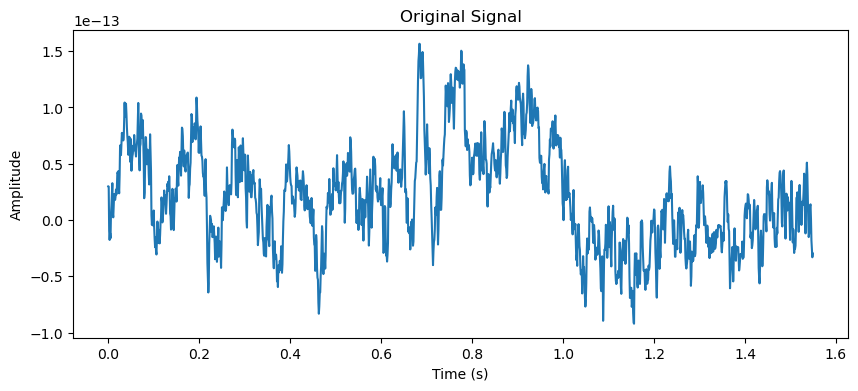

In [36]:
# visualize original signal
trial_data, n_times = process_single_trial(anticipatory_t1_top50_channels, trial_idx=0)

In [37]:
# function to add buffer: padding 15 seconds on each side of a ~1-second signal 
# add zero-padding before the signal (before 0.5s) and after the signal (after 1.55s)
"""
[-15.0s]        [0.0s]       [1.05s]         [+15.0s]
   |------------|============|------------|
       pad       real data        pad
"""


def add_buffer(trial_data, detrend=True):
    
    #dd zero padding (constant with zeros) as shown in MNE examples
    padded_data = np.pad(trial_data, pad_width=buffer_points, mode='constant', constant_values=0)
    
    # See what the padded data looks like
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(padded_data))/sfreq, padded_data)
    
    plt.title("Zero-padded Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (magnetic field strength in tesla)")
    plt.legend()
    plt.show()
    
    # Reshape for MNE
    data_tfr = padded_data.reshape(1, 1, -1)
    print(f"Reshaped data dimensions: {data_tfr.shape}")
    
    return data_tfr

/scratch/ipykernel_1252879/2608025044.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


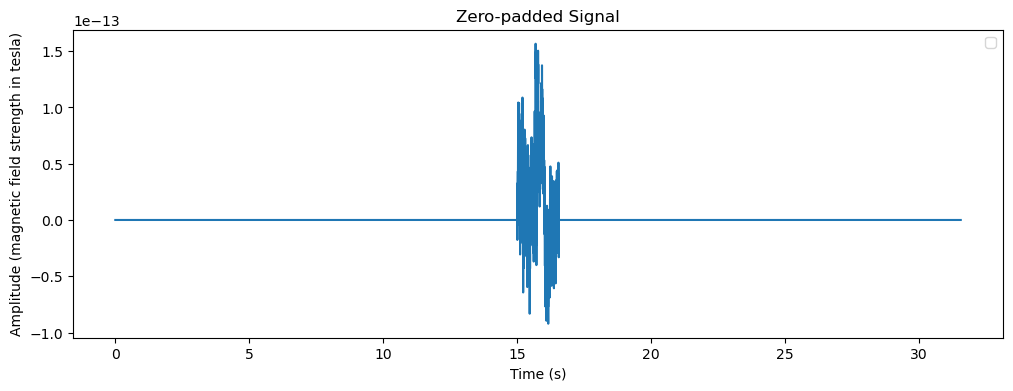

Reshaped data dimensions: (1, 1, 31550)


In [38]:
data_tfr = add_buffer(trial_data)

In [39]:
# function to run wavelet transform 
def run_wavelet(data_tfr):
    try:
        # Apply Morlet wavelet transform
        tfr = tfr_array_morlet(data_tfr, sfreq=sfreq, freqs=freqs,
                             n_cycles=n_cycles, output='power')
        
        print(f"TFR output dimensions: {tfr.shape}")
       
        return tfr
    
    except ValueError as e:
        print(f"Error running wavelet transform: {e}")
        return None

In [40]:
# data_tfr is the padded data
tfr = run_wavelet(data_tfr)
# output is (1, 1, 10, 31050): epochs, channel(s), freqs, timepoints (w padding) 
#  down to 1 channel because I averaged across all 50 channels beforehand 

TFR output dimensions: (1, 1, 10, 31550)


In [ ]:

def extract_and_plot(tfr, n_times, title="Time-Frequency Analysis"):
    if tfr is None:
        return None
    
    print(f"TFR shape: {tfr.shape}")
    
    # Extract the relevant portion (remove buffer)
    result = tfr[0, 0, :, buffer_points:buffer_points+n_times]
    print(f"Final result dimensions: {result.shape}")
    
    # Check the range of values
    print(f"Power range: {np.min(result):.2e} to {np.max(result):.2e}")
    
    # Create time vector
    times = np.arange(n_times) / sfreq
    
    # Define baseline period (assuming trial_data includes pre-precue period)
    if len(trial_data) > 500:  # If we have pre-precue data
        baseline_start_idx = 0
        baseline_end_idx = 500  # 500ms pre-precue period
        
        # Calculate baseline (mean power during pre-precue period)
        baseline = np.mean(result[:, baseline_start_idx:baseline_end_idx], axis=1, keepdims=True)
        
        # Apply baseline correction (SUBTRACT baseline power)
        result_corrected = result - baseline
    else:
        # No pre-precue data available
        result_corrected = result.copy()  # No correction
    
    # Plot original (non-corrected) result
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, freqs, result, shading='gouraud', cmap='viridis')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(f"{title} - Without Baseline Correction")
    plt.colorbar(label='Power')
    plt.show()
    
    # Plot baseline-corrected result (if correction was applied)
    if len(trial_data) > 500:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(times, freqs, result_corrected, shading='gouraud', cmap='viridis')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(f"{title} - With Baseline Correction")
        plt.colorbar(label='Power (baseline subtracted)')
        plt.show()
    
    return result, result_corrected if len(trial_data) > 500 else result

TFR shape: (1, 1, 10, 31550)
Final result dimensions: (10, 1550)
Power range: 1.49e-29 to 6.77e-25


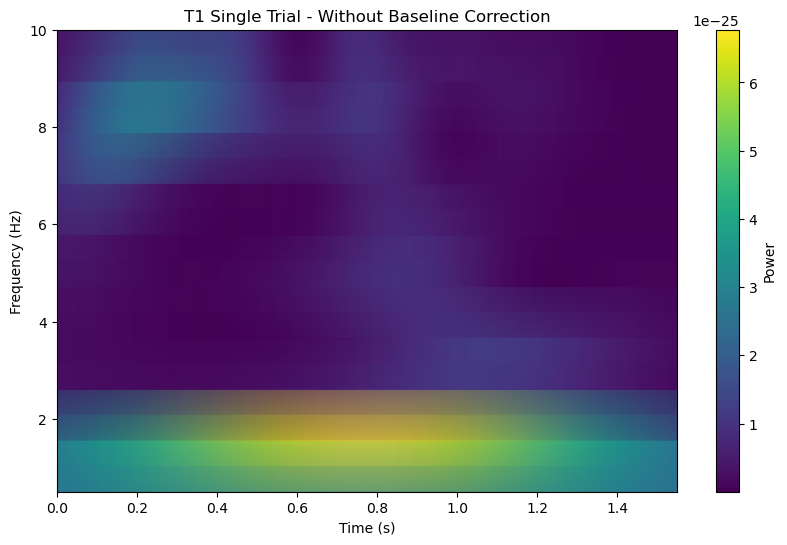

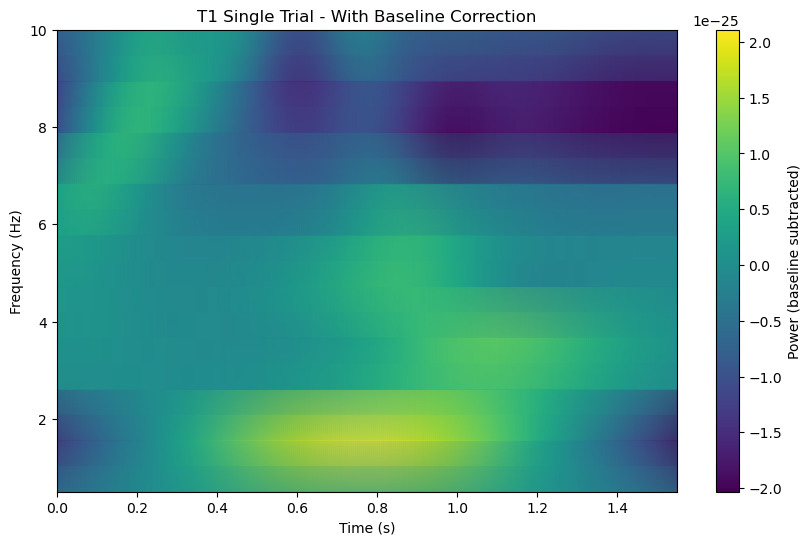

In [42]:
result = extract_and_plot(tfr, n_times, title="T1 Single Trial")

In [44]:
# Assuming anticipatory_t1_top50_channels is  epoched data
n_timepoints = anticipatory_t1_top50_channels.shape[0]
epoch_duration = n_timepoints / sfreq  # in seconds
print(f"Epoch duration: {epoch_duration} seconds")

Epoch duration: 1.55 seconds
